In [1]:
# Dynamic
%matplotlib notebook
# Standard
# %matplotlib inline

from copy import deepcopy
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
import pandas
import pickle
from scipy.stats import sem, rankdata
import seaborn as sns
import sys


# Allow to import the modules in the model folder
sys.path.append('../model/')

fig_width = 16  # full screen: 16 / half screen: 10
fig_height = 8

In [2]:
# /!\ global variables
"""
Possible diversity_threshold values:
100, 250, 500, 750, 
1000, 1250, 1500, 1750, 1875,
2000, 2250, 2500, 2750, 
3000, 3250, 3500, 3750, 
4000, 4500,
5000, 5500,
6000
"""
# l_div_th = [100, 250, 500, 750,1000,
#             1250, 1500, 1750, 1875, 2000,
#             2250, 2500, 2750, 3000 ,3500,
#             4000 ,5000]  # for nlm_div_th_test
# l_div_th = [500, 1000, 1500, 2000, 2500,
#             3000, 3500, 4000, 4500, 5000]  # for 0.25_0.25_0.25_0.25 short and long and 0.2_0.2_0.5_0.1
l_div_th = [500, 1000, 1500, 2000, 2500, 
            2750, 3000, 3250, 3500, 3750,
            4000, 4500, 5000, 5500, 6000]  # for 0.1_0.1_0.75_0.05 short and long

coef_param = '0p_1rms'  # for nlm_div_th_test
l_seed = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

sim_nb_day = 60  # 30 or 60 for long simulations, used as the stop parameter in delta_learning_step function

plot_title = "10_10_75_5 diff dev & long "  # specify the title of the plot for better identification of the figures

nb_seed = len(l_seed)

In [3]:
def delta_learning_step(start, stop):
    """
    For each "learning step" (one day plus one night),
    calculate and store the "delta" (the difference) between
    the best score of the morning songs and the best score of the evening songs of the previous day.
    
    returns:
    - full_data: store the deltas for each diversity_threshold (each parameters set) 
                 and for each seeds computed under these parameters set
    - final_scores: for all the simulations, store the final score which is the best score
                    among the final songs learned by the bird
    - percent_changes
    /!\: use l_div_th, l_seed and coef_param as global variable
    """
    full_data = []
    final_scores = []
    percent_changes = []
    for i_div_th, div_th in enumerate(l_div_th):
        """
        For one diversity_threshold,
        for each time window == learning step == 1 day + 1 night,
        store all the differences for all the seeds 
        """
        print("{} ({}/{})".format(div_th, i_div_th+1, len(l_div_th)))
        seeds_diff = None
        cluster_percent_changes = None
        for i_seed in l_seed:
            print("\t{} ({}/{})".format(i_seed, i_seed+1, len(l_seed)))
            """nlm_div_th_test_180713_173751"""
#             path = '../model/res/nlm_div_th_test_180713_173751/'
#             path += 'seed{}'.format(i_seed)            
#             path += '+nlm_div_th_test+'+coef_param
#             path += '+{}_diversity_th'.format(div_th)
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
            """grid_div_th_180803_023956
            proba: delete=0.25 ; split=0.25 ; move=0.25 ; nothing=0.25"""
#             path = '../model/res/grid_div_th_180803_023956/'
            """grid_div_th_180807_173606 
            proba: delete=0.3 ; split=0.2 ; move=0.3 ; nothing=0.2"""
#             path = '../model/res/grid_div_th_180807_173606/'
            """grid_div_th_180810_121231 
            proba: delete=0.2 ; split=0.2 ; move=0.5 ; nothing=0.1"""
#             path = '../model/res/grid_div_th_180810_121231/'
            """grid_div_th_180813_213247
            proba: delete=0.1 ; split=0.1 ; move=0.75 ; nothing=0.05"""
#             path = '../model/res/grid_div_th_180813_213247/'
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
            """long_grid_div_th_180816_120049
            60 days ; different deviation parameters
            proba: delete=0.25 ; split=0.25 ; move=0.25 ; nothing=0.25"""
#             path = '../model/res/long_grid_div_th_180816_120049/'
            """long_grid_div_th_180821_183837
            60 days ; different deviation parameters
            proba: delete=0.10 ; split=0.10 ; move=0.75 ; nothing=0.05"""
            path = '../model/res/long_grid_div_th_180821_183837/'
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
            # -- common grid_div_th parameters --
            path += 'seed{}'.format(i_seed)
            if 'long' in path:
                path += '+long_grid_div_th'
            else:
                path += '+grid_div_th'
            path += '+{}_diversity_th'.format(div_th)
# -------------------------------------------------------------------------
# -------------------------------------------------------------------------
            with open(join(path, 'data.pkl'), 'rb') as f:
                songlog = pickle.load(f)
            root_data = [item[1] for item in songlog if item[0] == 'root']
            rd = pandas.DataFrame(root_data)
            # Store best final score
            final_scores.append(np.min(rd['scores'].iloc[stop-1]))
            deltas = []
            percent_deltas = []
            for i in range(start, stop, 2):
                end = np.min(rd['scores'].iloc[i])
                beg = np.min(rd['scores'].iloc[i - 1])
                deltas.append(end - beg)
                # percentage change: if negative, improvement ; if positive, degradation
                percent_deltas.append((end - beg) / beg)
            deltas = np.asarray(deltas)
            percent_deltas = np.array(percent_deltas)
            # Initialization
            if seeds_diff is None:
                seeds_diff = deltas
            # Concatenation
            else:
                seeds_diff = np.vstack((seeds_diff, deltas))
            # Initialization
            if cluster_percent_changes is None:
                cluster_percent_changes = percent_deltas
            # Concatenation
            else:
                cluster_percent_changes = np.vstack((cluster_percent_changes, percent_deltas))
        full_data.append(seeds_diff)
        percent_changes.append(cluster_percent_changes)
    final_scores = np.array(final_scores).reshape((-1, len(l_seed)))
    print("finish!")
    return full_data, final_scores, percent_changes

# Calculations

In [4]:
night_data, final_scores, night_p_ch = delta_learning_step(2, sim_nb_day * 2)

500 (1/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
1000 (2/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
1500 (3/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
2000 (4/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
2500 (5/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
2750 (6/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
3000 (7/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
3250 (8/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9/10)
	9 (10/10)
3500 (9/15)
	0 (1/10)
	1 (2/10)
	2 (3/10)
	3 (4/10)
	4 (5/10)
	5 (6/10)
	6 (7/10)
	7 (8/10)
	8 (9

In [5]:
# day_data, final_scores, day_p_ch = delta_learning_step(1, sim_nb_day * 2)

In [6]:
# for i in range(len(night_data)):
#     print("div_th = {}:".format(l_div_th[i]))
#     m_night = np.mean(np.median(night_data[i], axis=0))
#     m_day = np.mean(np.median(day_data[i], axis=0))
#     print("global mean degradation per night: {}".format(m_night))
#     print("global mean optimization per day: {}".format(m_day))
#     print("difference: {}".format(m_night + m_day))
#     print()

# An example of the 2 type of graph

In [7]:
# # Scatter plot
# i = 1
# seeds_diff = night_data[i]  #shape = (nb_seeds x nb_nights)
# plt.figure(figsize=(fig_width,fig_height))
# for i_song in range(len(seeds_diff)):
#     plt.plot(np.arange(1,len(seeds_diff[i_song]) + 1), seeds_diff[i_song], 'o', color='C0')
# plt.plot(np.arange(1,seeds_diff.shape[1] + 1), np.mean(seeds_diff, axis=0),
#          'o', color='C1', label="mean degradation per night")
# plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
# plt.legend()
# plt.title("diversity_threshold = {} ; {}\n (mean of 'mean degradation per night': {})".format(l_div_th[i], coef_param, round(np.mean(seeds_diff), 3)))
# plt.show()

# # Box plot
# plt.figure(figsize=(fig_width,fig_height))
# plt.boxplot(seeds_diff)
# plt.plot(np.arange(1,seeds_diff.shape[1] + 1), np.mean(seeds_diff, axis=0),
#          'o', color='C1', label="mean degradation per night")
# plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
# plt.legend()
# plt.title("diversity_threshold = {} ; {}\n (mean of 'mean degradation per night': {})".format(l_div_th[i], coef_param, round(np.mean(seeds_diff), 3)))
# plt.show()

# Night percentage changes per bird for each day

In [8]:
# for i in range(len(night_p_ch)):  # for each div_th (parameters set)
#     cluster_p_ch = deepcopy(night_p_ch[i])  #shape = (nb_seeds x nb_nights)
#     cluster_p_ch *= 100  # Changing scale value: from 0.05 to 5%
#     cluster_p_ch *= -1  # signed score percentage change (negative if against the overall developmental trend)
        
#     fig = plt.figure(figsize=(fig_width,fig_height))
#     # -- scatter plot --
#     for i_bird in range(len(cluster_p_ch)):
#         plt.plot(np.arange(1,len(cluster_p_ch[i_bird]) + 1), cluster_p_ch[i_bird],
#                  'o', color='C0')
#     median_p_ch_per_night = np.median(cluster_p_ch, axis=0)
#     plt.plot(np.arange(1,cluster_p_ch.shape[1] + 1), median_p_ch_per_night,
#              'D', color='C1', label="median changes per night (%)")
#     plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
#     plt.xlabel("day")
#     plt.ylabel("distance error changes after a night (%)")
#     plt.ylim(-55, 25)  # Same scale for all the figures
#     plt.legend()
#     str_title = "diversity_threshold = {} ({})\n".format(l_div_th[i], plot_title)
#     str_title += "median across song development (%)' = {}".format(round(np.median(cluster_p_ch), 3))
#     plt.title(str_title)
#     fig.tight_layout()
#     plt.show()

Aggregation of all the birds with different div_th values

<IPython.core.display.Javascript object>


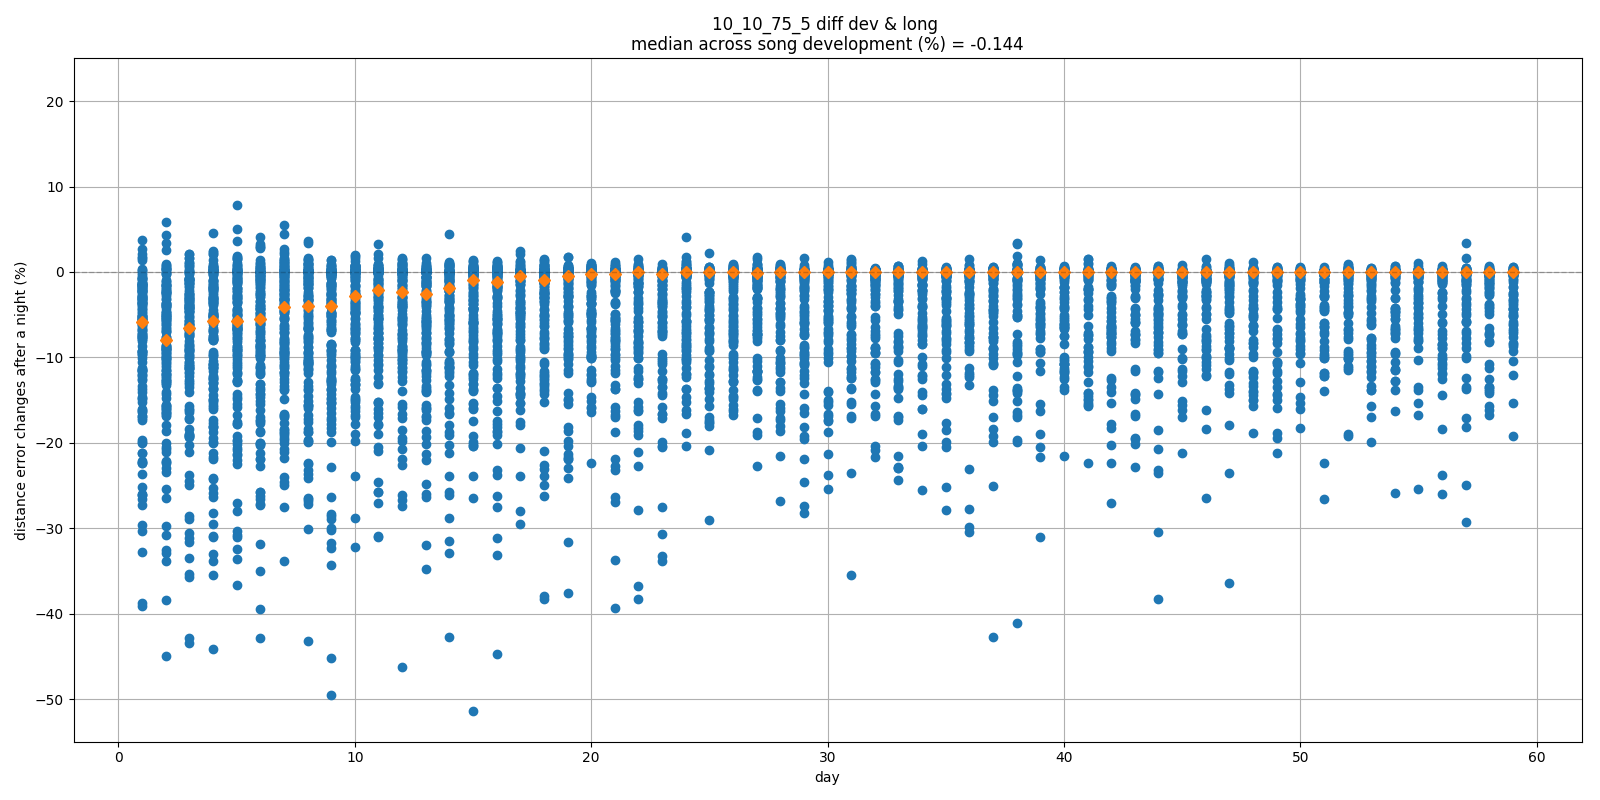

In [7]:
all_birds_p_ch = deepcopy(night_p_ch[0])  # Initialization
for i in range(1, len(night_p_ch)):
    all_birds_p_ch = np.concatenate((all_birds_p_ch, deepcopy(night_p_ch[i])))  # aggregation
all_birds_p_ch *= -100 # changing scale and sign

x = np.arange(1, all_birds_p_ch.shape[1] + 1)
fig = plt.figure(figsize=(fig_width, fig_height))
for i_bird in range(all_birds_p_ch.shape[0]):  # scatter plot
    plt.plot(x, all_birds_p_ch[i_bird], 'o', color="C0")
# plt.boxplot(all_birds_p_ch)  " boxplot"
median_p_ch_per_night = np.median(all_birds_p_ch, axis=0)
plt.plot(x, median_p_ch_per_night, 'D', color="C1",
         label="median changes per night (%)")
plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
plt.xlabel("day")
plt.ylabel("distance error changes after a night (%)")
plt.ylim(-55, 25)  # Same scale for all the figures
# plt.ylim(-10,1)  # zoom on the median values
plt.grid()
str_title = "{}\n".format(plot_title)
str_title += "median across song development (%) = {}".format(round(np.median(all_birds_p_ch), 3))
plt.title(str_title)
fig.tight_layout()
plt.show()

# night degradation per bird for each simulation day

In [9]:
# for i in range(len(night_data)):  # for each div_th (parameters set)
#     birds_diff = night_data[i]  #shape = (nb_seeds x nb_nights)
        
#     plt.figure(figsize=(fig_width,fig_height))
#     # -- scatter plot --
#     for i_bird in range(len(birds_diff)):
#         plt.plot(np.arange(1,len(birds_diff[i_bird]) + 1), birds_diff[i_bird], 'o', color='C0')
#     # -- box plot --
# #     plt.boxplot(seeds_diff)
#     mean_deg_per_night = np.mean(birds_diff, axis=0)
#     median_deg_per_night = np.median(birds_diff, axis=0)
#     plt.plot(np.arange(1,birds_diff.shape[1] + 1), mean_deg_per_night,
#              'o', color='C1', label="mean degradation per night")
#     plt.plot(np.arange(1,birds_diff.shape[1] + 1), median_deg_per_night,
#              'D', color='C2', label="median degradation per night")
#     plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
#     plt.xlim(0, 30)
#     plt.ylim(-2, 4)
#     plt.legend()
#     str_title = "diversity_threshold = {}\n".format(l_div_th[i])
#     str_title += "mean of 'mean degradations per night' = {}\n".format(round(np.mean(mean_deg_per_night), 3))
#     str_title += "mean of 'median degradations per night' = {}".format(round(np.mean(median_deg_per_night), 3))
#     plt.title(str_title)
#     plt.show()

# day optimization for each simulation day

In [10]:
# for i in range(len(day_data)):
#     seeds_diff = deepcopy(day_data[i])
    
#     plt.figure(figsize=(fig_width,fig_height))
#     # -- scatter plot --
#     for i_song in range(len(seeds_diff)):
#         plt.plot(np.arange(1,len(seeds_diff[i_song]) + 1), seeds_diff[i_song], 'o', color='C0')
#     # -- box plot --
# #     plt.boxplot(seeds_diff)
#     plt.plot(np.arange(1,seeds_diff.shape[1] + 1), np.mean(seeds_diff, axis=0),
#              'o', color='C1', label="mean optimization per day")
#     plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
#     plt.legend()
#     plt.title("diversity_threshold = {}\nmean of 'mean optimization per day': {})".format(l_div_th[i], round(np.mean(seeds_diff), 3)))
#     plt.show()

# distribution of the degradations and the optimizations

In [11]:
# for i in range(len(l_div_th)):
#     plt.figure(figsize=(fig_width,fig_height))
#     sns.distplot(night_data[i].flatten(), kde=False, label="night degradation")
#     sns.distplot(day_data[i].flatten(), kde=False, label="day optimization")
#     plt.axvline(x=0, color="k", linewidth=1, alpha=0.2, ls="--")
#     plt.xlim(-8,8)
#     plt.xticks(np.arange(-8,9,1), np.arange(-8,9,1))
#     plt.legend()
# #     plt.title("diversity_threshold {} ; {}".format(l_div_th[i], coef_param))
#     plt.title("diversity_threshold {}".format(l_div_th[i]))
#     plt.show()

### Observations (peut être plus à jour :p... ):

- Plus la valeur du paramètre diversity_threshold augmente, plus la dégradation moyenne nocturne et l'optimisation dans la journée ont des effets moindres (moins de dégradations et moins d'optimisations)

- Les améliorations moyennes sont plus élevées que les dégradations moyennes

- Une valeur de diversity_threshold élevée peut permettre de sélectionner des chants de structures différentes, mais dont les scores ne sont pas fortement dégradés pour autant car le score est impliqué dans le calcul de la fitness

- Lors des optimisations, pendant le jour, on ne fait qu'améliorer le score (logique au vu du déroulement de l'algorithme)

- Lors des dégradations, pendant la nuit, il arrive qu'à la sélection finale pour les chants du jour suivant, le choix améliore le score des chants
    - On le remarque particulièrement avec diversity_threshod = 2000 où au final, il y a beaucoup de petites améliorations. D'où l'obtention de scores faibles avec cette valeur de paramètre.


Idée de la fonction de fitness: Avoir un score faible et avoir un nombre de voisin faible

Un chant avec cette propriété sera sélectionné, il va donc crée un clone muté. Or ce clone risque d'être proche du chant, donc devenir un potentiel voisin. Rendant alors le chant sélectionner et son clone moins intéressant...

# Scatter plot: night degradation vs. score inverted (final song quality)

### MEAN degradation per night for each BIRD

- abscissa: the mean degradation per night during the development of 1 bird
- ordinate: the mean error distance value over the 3 final songs learned by the bird

In [12]:
# fig = plt.figure(figsize=(fig_width, fig_height))
# for i in range(len(night_data)):
#     birds_diff = np.mean(night_data[i], axis=1)
#     birds_score = -1 * final_scores[i]
#     plt.plot(birds_diff, birds_score,
#              'o', color="C{}".format(i),
#              label="div_th {}".format(l_div_th[i]))
# plt.grid()
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel("mean degradation per night")
# plt.ylabel("- distance error")
# plt.title('MEAN degradation per night vs. -dist_err per BIRD')
# fig.tight_layout()
# plt.show()   

### MEDIAN degradation per night for each BIRD (aggregation of the 3 songs per simulation)

- abscissa: the median degradation per night during the development of 1 bird
- ordinate: the mean error distance value over the 3 final songs learned by the bird

In [13]:
# fig = plt.figure(figsize=(fig_width, fig_height))
# for i in range(len(night_data)):
#     birds_diff = np.median(night_data[i], axis=1)
#     birds_score = -1 * final_scores[i]        
#     plt.plot(birds_diff, birds_score,
#              'D', color="C{}".format(i),
#              label="div_th {}".format(l_div_th[i]))
# plt.grid()
# plt.legend(fontsize="small")
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel("median degradation per night")
# plt.ylabel("- distance error")
# plt.title('MEDIAN degradation per night vs. -dist_err per BIRD')
# fig.tight_layout()
# plt.show()   

### MEAN degradation per nigth for each cluster of birds

- 1 cluster of birds:
    - ex: 10 seeds and 1 parameter set gives 1 cluster of 10 birds

Mean score of the cluster (mean of the mean score of each bird (mean of its 3 songs) in the cluster)

In [14]:
# fig = plt.figure(figsize=(fig_width, fig_height))
# for i in range(len(night_data)):
#     cluster_diff = np.mean(night_data[i], axis=1)
#     cluster_mean_deg = np.mean(cluster_diff)
#     sem_deg = sem(cluster_diff)
#     cluster_mean_score = -np.mean(final_scores[i])
#     sem_score = sem(final_scores[i])
    
#     plt.errorbar(x=cluster_mean_deg, y=cluster_mean_score,
#                  xerr=sem_deg, yerr=sem_score,  # plot errorbar
#                  fmt='o', color="C{}".format(i),
#                  label="div_th {}".format(l_div_th[i]))
#     # plot each bird result
# #     plt.plot(cluster_diff, cluster_score,
# #              'x', color="C{}".format(i))
# plt.grid()
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel("mean of mean degradations per night")
# plt.ylabel("opposite of the mean of mean error distances)")
# plt.title('Correlation between post-sleep deterioration and quality of the song per CLUSTER')
# fig.tight_layout()
# plt.show()   

Median score of the cluster (median of the mean score of each bird in the cluster)

In [15]:
# fig = plt.figure(figsize=(fig_width, fig_height))
# for i in range(len(night_data)):
#     cluster_diff = np.mean(night_data[i], axis=1)
#     cluster_mean_deg = np.mean(cluster_diff)
#     sem_deg = sem(cluster_diff)
#     cluster_median_score = -np.median(final_scores[i])
# #     q1_score = np.percentile(final_scores[i], 25)
# #     q3_score = np.percentile(final_scores[i], 75)
# #     yerr = np.array([[cluster_median_score - q1_score],
# #                      [q3_score - cluster_median_score]])
#     yerr = sem(final_scores[i])  # standard error of measure
    
#     plt.errorbar(x=cluster_mean_deg, y=cluster_median_score,
#                  xerr=sem_deg, yerr=yerr,
#                  fmt='o', color="C{}".format(i),
#                  label="div_th {}".format(l_div_th[i]))
#     # plot each bird result
# #     plt.plot(cluster_diff, cluster_score,
# #              'x', color="C{}".format(i))
# plt.grid()
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel("mean degradation per night")
# plt.ylabel("- median(dist_err)")
# plt.title('MEAN degradation per night vs. - MEDIAN(dist_err) per CLUSTER')
# fig.tight_layout()
# plt.show()   

### MEDIAN degradation per nigth for each cluster of birds

- 1 cluster of birds:
    - ex: 10 seeds and 1 parameter set gives 1 cluster of 10 birds

Mean score of the cluster (mean of the mean score of each bird in the cluster)

In [16]:
# fig = plt.figure(figsize=(fig_width, fig_height))
# for i in range(len(night_data)):
#     cluster_median_deg = np.median(night_data[i])
# #     q1_deg = np.percentile(night_data[i], 25)
# #     q3_deg = np.percentile(night_data[i], 75)
# #     xerr = np.array([[cluster_median_deg - q1_deg],
# #                      [q3_deg - cluster_median_deg]])
#     xerr = sem(np.median(night_data[i], axis=1))  # standard error of measure
#     cluster_mean_score = -np.mean(final_scores[i])
#     sem_score = sem(final_scores[i])  # standard error of measure
    
#     plt.errorbar(x=cluster_median_deg, y=cluster_mean_score,
#                  xerr=xerr, yerr=sem_score,  # plot errorbar
#                  fmt='D', color="C{}".format(i),
#                  label="div_th {}".format(l_div_th[i]))
#     # plot each bird result
# #     plt.plot(cluster_diff, cluster_score,
# #              'x', color="C{}".format(i))
# plt.grid()
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel("median degradation per night")
# plt.ylabel("- mean(dist_err)")
# plt.title('MEDIAN degradation per night vs. - MEAN(dist_err) per CLUSTER')
# fig.tight_layout()
# plt.show()   

Median score of the cluster (median of the mean score of each bird in the cluster)

In [17]:
# fig = plt.figure(figsize=(fig_width, fig_height))
# for i in range(len(night_data)):
#     cluster_median_deg = np.median(night_data[i])
# #     q1_deg = np.percentile(night_data[i], 25)
# #     q3_deg = np.percentile(night_data[i], 75)
# #     xerr = np.array([[cluster_median_deg - q1_deg],
# #                      [q3_deg - cluster_median_deg]])
#     xerr = sem(np.median(night_data[i], axis=1))  # standard error of measure
#     cluster_median_score = -np.median(final_scores[i])
# #     q1_score = np.percentile(final_scores[i], 25)
# #     q3_score = np.percentile(final_scores[i], 75)
# #     yerr = np.array([[cluster_median_score - q1_score],
# #                      [q3_score - cluster_median_score]])
#     yerr = sem(final_scores[i])  # standard error of measure
    
#     plt.errorbar(x=cluster_median_deg, y=cluster_median_score,
#                  xerr=xerr, yerr=yerr,  # plot errorbar
#                  fmt='D', color="C{}".format(i),
#                  label="div_th {}".format(l_div_th[i]))
#     # plot each bird result
# #     plt.plot(cluster_diff, cluster_score,
# #              'x', color="C{}".format(i))
# plt.grid()
# plt.legend(bbox_to_anchor=(1,1), loc="upper left")
# plt.xlabel("median degradation per night")
# plt.ylabel("- median(dist_err)")
# plt.title('MEDIAN degradation per night vs. - MEDIAN(dist_err) per CLUSTER')
# fig.tight_layout()
# plt.show()   

# Closer to the Derégnaucourt et al. figure?

In [18]:
magic_i = 6
print(l_div_th[magic_i:])

[1500, 1750, 1875, 2000, 2250, 2500, 2750, 3000, 3500, 4000, 5000]


Median value over all the night changes in the cluster / Mean of the final songs' score of the bird in the cluster

In [19]:
cluster_median_deg = 100 * np.median(np.array(night_p_ch[magic_i:]), axis=[1,2])
cluster_mean_score = -1 * np.mean(final_scores[magic_i:], axis=1)
z_cluster = np.polyfit(cluster_median_deg, cluster_mean_score,1)
p_median_cluster = np.poly1d(z_cluster)
# Spearman's rank correlation coefficient
r_x = rankdata(cluster_median_deg)
r_y = rankdata(cluster_mean_score)
cluster_spearman_corr_coef = np.corrcoef(r_x, r_y)[0, 1]
print("Spearman's rank correlation coefficient:", cluster_spearman_corr_coef)

Spearman's rank correlation coefficient: 0.6578891865794587


For each bird,  the median night percentage degradation during all the development and the mean value of its final songs' scores

In [20]:
# median percentage night deg for each bird
x_all_birds = 100 * np.median(np.concatenate(night_p_ch[magic_i:], axis=0), axis=1).flatten()
y_all_birds = -1 * np.concatenate(final_scores[magic_i:], axis=0).flatten()
# linear regression
z_all_birds = np.polyfit(x_all_birds, y_all_birds, 1)
print(z_all_birds)
p_all_birds = np.poly1d(z_all_birds)
# Spearman's rank correlation coefficient
r_x = rankdata(x_all_birds)
r_y = rankdata(y_all_birds)
spearman_corr_coef = np.corrcoef(r_x, r_y)[0, 1]
print("Spearman's rank correlation coefficient:", spearman_corr_coef)

[ 2.81409517e-03 -8.59189253e+00]
Spearman's rank correlation coefficient: 0.10012702029099751


# Correlation plots

In [21]:
# give all the plots the same shape
xmin, xmax, xstep = (-1, 8, 1)
ymin, ymax, ystep = (-11, -5, 0.25)

Abscissa: the median value over all the night changes on the cluster

<IPython.core.display.Javascript object>


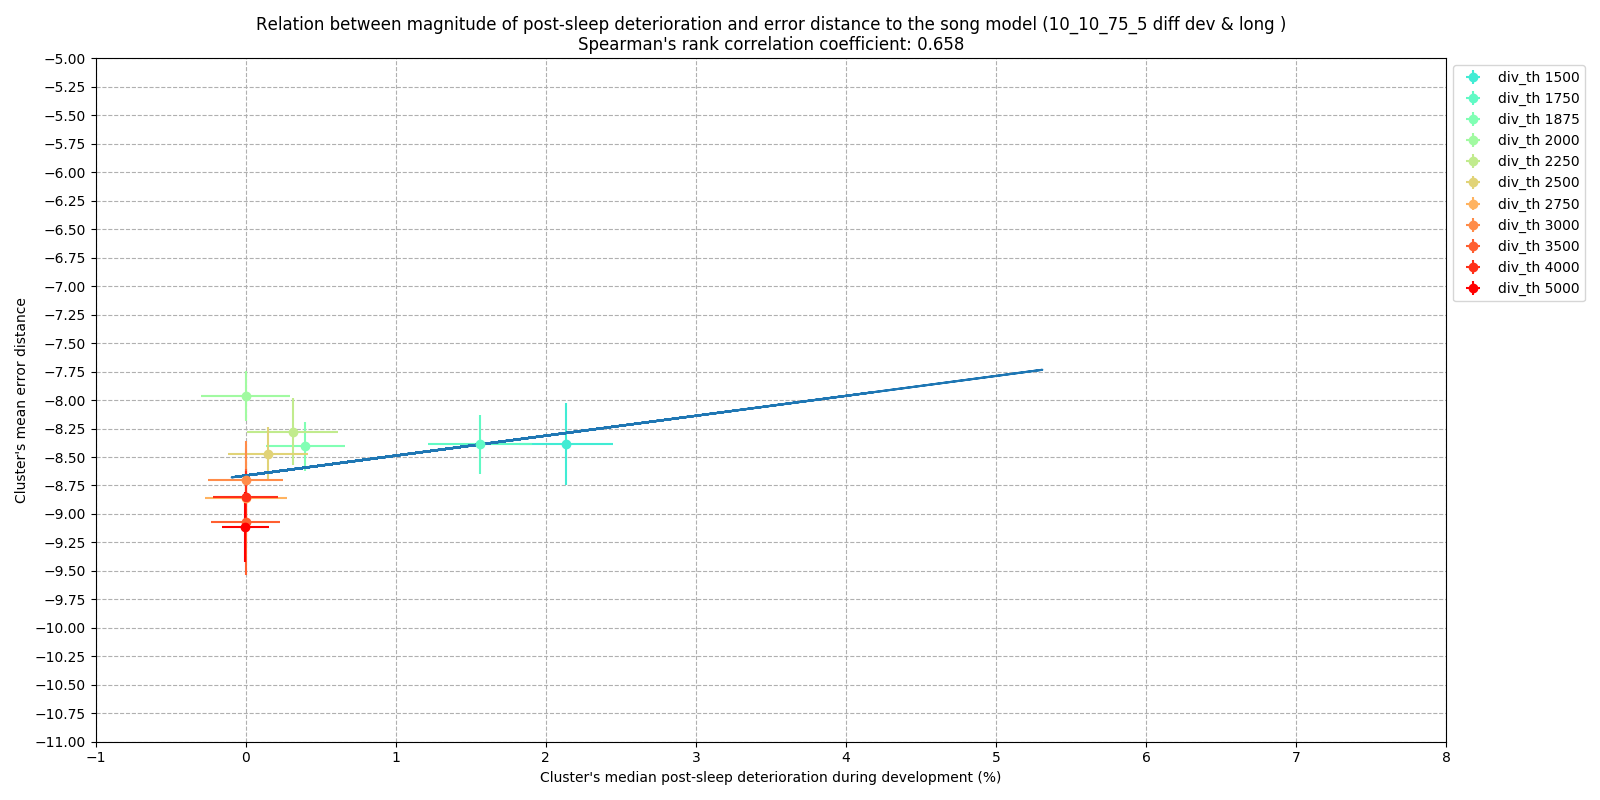

In [22]:
color_id = np.linspace(0, 1, len(night_data))
fig = plt.figure(figsize=(fig_width, fig_height))
for i in range(magic_i, len(night_data)):
    # median of all the night changes and % scale
    cluster_median_percent_change = 100 * np.median(night_p_ch[i])
    xerr = sem(100 * night_p_ch[i].flatten())
    cluster_mean_score = -np.mean(final_scores[i])
    yerr = sem(final_scores[i])   
    plt.errorbar(x=cluster_median_percent_change, y=cluster_mean_score,
                 xerr=xerr, yerr=yerr,
                 fmt='o', color=plt.cm.rainbow(color_id[i]),
                 label="div_th {}".format(l_div_th[i]))
# -- Linear regressions --
plt.plot(x_all_birds, p_median_cluster(x_all_birds))

plt.xticks(np.arange(xmin, xmax + xstep))
plt.xlim(xmin, xmax)
plt.yticks(np.arange(ymin, ymax + ystep, ystep))
plt.ylim(ymin, ymax)
plt.grid(ls='--')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Cluster's median post-sleep deterioration during development (%)")
plt.ylabel("Cluster's mean error distance")
str_title = "Relation between magnitude of post-sleep deterioration and error distance to the song model" 
str_title += " ({})".format(plot_title)
str_title += "\nSpearman's rank correlation coefficient: {}".format(round(cluster_spearman_corr_coef, 3))
plt.title(str_title)
fig.tight_layout()
plt.show()   

<IPython.core.display.Javascript object>


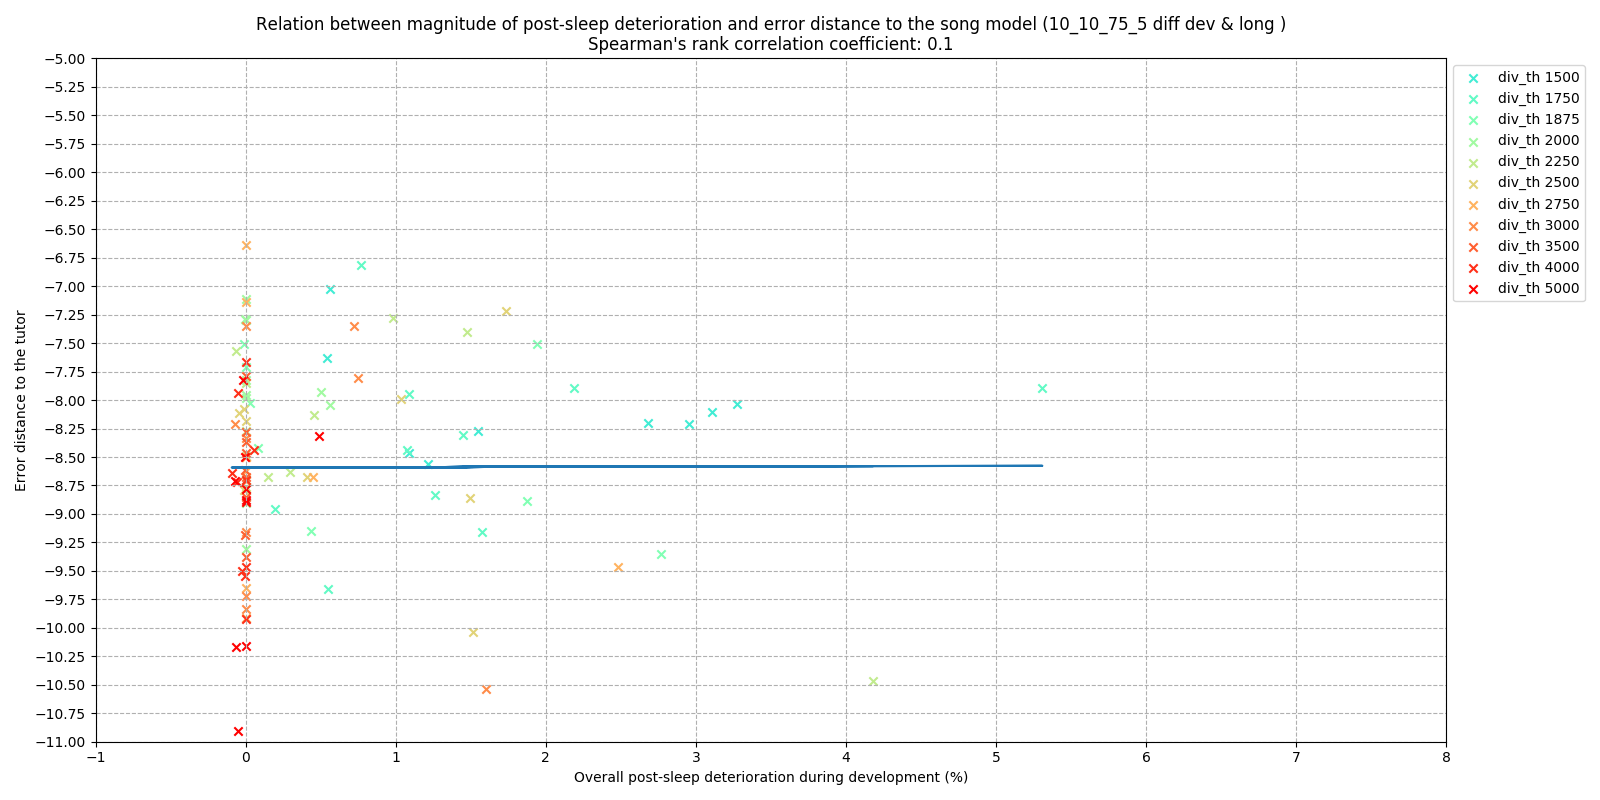

In [23]:
color_id = np.linspace(0, 1, len(night_data))
fig = plt.figure(figsize=(fig_width, fig_height))
for i in range(magic_i, len(night_data)):
    # -- plot each bird --
    x_birds = 100 * np.median(night_p_ch[i], axis=1)
    plt.scatter(x=x_birds, y=-1 * final_scores[i],
                c=plt.cm.rainbow(color_id[i]),
                marker='x', label="div_th {}".format(l_div_th[i]))
# -- Linear regressions --
plt.plot(x_all_birds, p_all_birds(x_all_birds))

plt.xticks(np.arange(xmin, xmax + xstep))
plt.xlim(xmin, xmax)
plt.yticks(np.arange(ymin, ymax + ystep, ystep))
plt.ylim(ymin, ymax)
plt.grid(ls='--')
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.xlabel("Overall post-sleep deterioration during development (%)")
plt.ylabel("Error distance to the tutor")
str_title = "Relation between magnitude of post-sleep deterioration and error distance to the song model" 
str_title += " ({})".format(plot_title)
str_title += "\nSpearman's rank correlation coefficient: {}".format(round(spearman_corr_coef, 3))
plt.title(str_title)
fig.tight_layout()
plt.show()  

# Delta of learning step (1 simulation)

In [24]:
# l_seed = [0, 1, 2, 3, 4]

# night_data = np.array([])
# day_data = np.array([])

# for i_seed in l_seed:
#     path = '../model/res/dev_test_180717_115457/'
#     path += 'seed{}'.format(i_seed)
#     path += '+default_dev+dev_test'

#     with open(join(path, 'data.pkl'), 'rb') as f:
#         songlog = pickle.load(f)
#     root_data = [item[1] for item in songlog if item[0] == 'root']
#     rd = pandas.DataFrame(root_data)

#     night_deltas = []
#     day_deltas = []

#     for i in range(1, len(rd)):
#         end = rd['scores'].iloc[i]
#         beg = rd['scores'].iloc[i - 1]
#         if i % 2 == 0:
#             night_deltas.append(end - beg)
#         else:
#             day_deltas.append(end - beg)
    
#     night_deltas = np.asarray(night_deltas)
#     day_deltas = np.asarray(day_deltas)
    
#     # Initialization
#     if len(night_data) == 0 and len(day_data) == 0:
#         night_data = night_deltas
#         day_data = day_deltas
#     # Concatenation
#     else:
#         night_data = np.concatenate((night_data, night_deltas), axis=1)
#         day_data = np.concatenate((day_data, day_deltas), axis=1)

In [25]:
# title_name = 'dev_test'

# plt.figure(figsize=(fig_width,fig_height))
# # -- scatter plot --
# for i_song in range(len(night_data.T)):
#     plt.plot(np.arange(1,len(night_data.T[i_song]) + 1), night_data.T[i_song], 'o', color='C0')
# plt.plot(np.arange(1,night_data.shape[0] + 1),
#          np.mean(night_data, axis=1),
#          'o', color='C1', label="mean degradation per night")
# plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
# plt.legend()
# plt.title("{}\n (mean of 'mean degradation per night': {})".format(title_name, round(np.mean(night_data), 3)))
# plt.show()
    
# plt.figure(figsize=(fig_width,fig_height))
# # -- scatter plot --
# for i_song in range(len(day_data.T)):
#     plt.plot(np.arange(1,len(day_data.T[i_song]) + 1), day_data.T[i_song], 'o', color='C0')
# plt.plot(np.arange(1,day_data.shape[0] + 1),
#          np.mean(day_data, axis=1),
#          'o', color='C1', label="mean optimization per day")
# plt.axhline(y=0, color="k", linewidth=1, alpha=0.2, ls="--")
# plt.legend()
# plt.title("{}\n mean of 'mean optimization per day': {}".format(title_name, round(np.mean(day_data), 3)))
# plt.show()

# plt.figure(figsize=(fig_width,fig_height))
# sns.distplot(night_data.flatten(), label="night degradation")
# sns.distplot(day_data.flatten(), label="day optimization")
# plt.xlim(-6, 6)
# plt.xticks(np.arange(-6,7,1), np.arange(-6,7,1))
# plt.legend()
# plt.title("{}\n distribution of score difference during learning".format(title_name))
# plt.show()